## Train a cellpose 2D model 

Before running this notebook a set of patches must exist in the following format.

1.  Ground Truth are put in a directory called ```/ground truth0```
2.  Inputs are put in a directory called ```inputn``` where n is an integer 0...m and represents the channel.  Note:  RGB images may only have one 'channel' directory.
3.  In each of the both directories there exist a set of files of the same names.  For example if in the ```inputn``` directory we have ```apples0```, ```apples1```, ```apples2``` label images of the same name must exist in the ```ground truth``` directory.  

In [3]:
import os
from tnia.plotting.plt_helper import imshow_multi2d
from cellpose import models, io
from pathlib import Path
from tnia.deeplearning.dl_helper import collect_training_data, divide_training_data

## Load inputs and ground truth

We load directories called 'input0' and 'ground truth0' which should exist under ```train_path```.  The reason we append '0' to the end of the name is because some of the code that generates image and label sets is meant to work on multiple channels (so the 0 is the channel number)

In [4]:
tnia_images_path = Path(r"D:\images")
parent_path = r'D:\images\tnia-python-images\imagesc\2024_10_11_tough_cellpose_2'

train_path = os.path.join(parent_path, 'patches')
#train_path = os.path.join(parent_path, 'labels')

image_patch_path = train_path + '/ground truth0'
label_patch_path = train_path + '/input0'

model_path = os.path.join(parent_path,'models')

if not os.path.exists(model_path):
    os.makedirs(model_path)

if not os.path.exists(image_patch_path):
    print('image_patch_path does not exist')

if not os.path.exists(label_patch_path):
    print('label_patch_path does not exist')

## Use a helper to collect the training data

The helper will also normalize the inputs.

In [5]:
X, Y = collect_training_data(train_path, sub_sample=1, downsample=False, normalize_input=False, add_trivial_channel=False, relabel=True)


print('Number of input images', len(X))
print('Number of ground truth images ', len(Y))

print('Size of first input image', X[0].shape)
print('Size of first ground truth image ', Y[0].shape)

  0%|          | 0/1200 [00:00<?, ?it/s]C:\Users\bnort\work\ImageJ2022\tnia\tnia-python\tnia\deeplearning\dl_helper.py:429: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  input_img = io.imread(os.path.join(input_path, input_files[i]), plugin='tifffile')
C:\Users\bnort\work\ImageJ2022\tnia\tnia-python\tnia\deeplearning\dl_helper.py:430: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  ground_truth_img = io.imread(os.path.join(truth_path, truth_files[i]), plugin='tifffile')
C:\Users\bnort\work\I

Number of input images 1200
Number of ground truth images  1200
Size of first input image (512, 512, 3)
Size of first ground truth image  (512, 512)


## Divide into training and validation sets

Unlike stardist Cellpose does not seem to need numpy arrays as input.  So to create training and validation sets we can simply split the X and Y vectors. 

In [6]:
X_train, Y_train, X_val, Y_val = divide_training_data(X, Y, 200, to_numpy=False)


X_train = X_train[:200]
Y_train = Y_train[:200]
X_val = X_val[:20]
Y_val = Y_val[:20]

print('Number of training images', len(X_train))
print('Number of validaiton images ', len(X_val))


Number of training images 200
Number of validaiton images  20


## Inspect images

Output training data shapes and plot images to make sure image and label set look OK 

(512, 512, 3) (512, 512)
0.19070241 1.0
float32 (512, 512, 3) 0.19070241 1.0


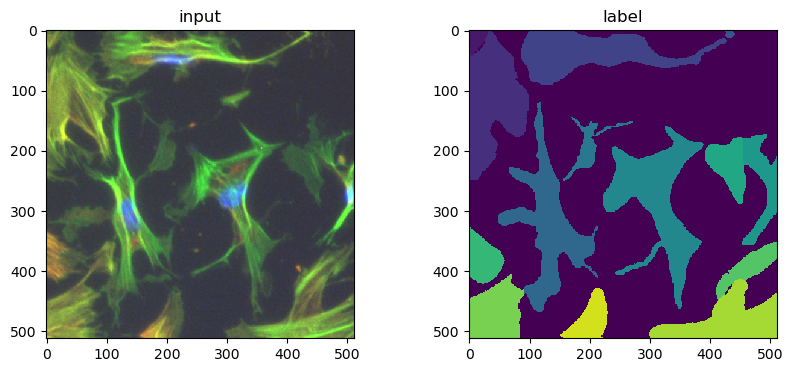

In [7]:
n=0
X_ = X_train[n]
Y_ = Y_train[n]

print(X_.shape, Y_.shape)
print(X_.min(), X_.max())
print(X_.dtype, X_.shape, X_.min(), X_.max())
fig=imshow_multi2d([X_, Y_], ['input', 'label'], 1,2)

## Create a cellpose model

In [8]:
import os

model_name = 'cellpose_testing_tnia_cpsam'

# start logger (to see training across epochs)
logger = io.logger_setup()

# DEFINE CELLPOSE MODEL
model= models.CellposeModel(gpu=True, pretrained_model=os.path.join(model_path,'models',model_name))
#model= models.CellposeModel(gpu=True, pretrained_model=None) #os.path.join(model_path,'models',model_name))

2025-05-15 09:32:44,182 [INFO] WRITING LOG OUTPUT TO C:\Users\bnort\.cellpose\run.log
2025-05-15 09:32:44,183 [INFO] 
cellpose version: 	4.0.1 
platform:       	win32 
python version: 	3.11.12 
torch version:  	2.6.0
2025-05-15 09:32:44,526 [INFO] ** TORCH CUDA version installed and working. **
2025-05-15 09:32:44,528 [INFO] >>>> using GPU (CUDA)
2025-05-15 09:32:46,620 [INFO] >>>> loading model D:\images\tnia-python-images\imagesc\2024_10_11_tough_cellpose_2\models\models\cellpose_testing_tnia_cpsam


# Train the model

In [14]:
import cellpose
from cellpose import train

major_number = cellpose.version.split('.')[0]
print(f"Cellpose version: {cellpose.version} (major number: {major_number})")

# convert major number to int
major_number = int(major_number)
n_epochs = 40
nimg_per_epoch = 100 

if major_number < 4:
    new_model_path = train.train_seg(model.net, X_train, Y_train, test_data=X_val, test_labels=Y_val,  
                                channels=[2,3], 
                                save_path=model_path, 
                                n_epochs=20,
                                min_train_masks=0,
                                rescale = False,  
                                model_name=model_name,
                                normalize=False,
                                bsize=512)
else:
    new_model_path = train.train_seg(model.net, X_train, Y_train, test_data=X_val, test_labels=Y_val,  
                                save_path=model_path, 
                                n_epochs=n_epochs,
                                min_train_masks=0,
                                rescale = False,  
                                model_name=model_name,
                                normalize=False,
                                nimg_per_epoch=nimg_per_epoch,
                                save_every=10,)

Cellpose version: 4.0.1 (major number: 4)
2025-05-13 18:55:15,621 [INFO] computing flows for labels


100%|██████████| 200/200 [00:55<00:00,  3.58it/s]

2025-05-13 18:56:11,758 [INFO] computing flows for labels



100%|██████████| 20/20 [00:05<00:00,  3.75it/s]

2025-05-13 18:56:17,112 [INFO] >>> computing diameters



100%|██████████| 20/20 [00:00<00:00, 869.52it/s]

2025-05-13 18:56:17,375 [INFO] >>> n_epochs=40, n_train=200, n_test=20
2025-05-13 18:56:17,376 [INFO] >>> AdamW, learning_rate=0.00005, weight_decay=0.10000
2025-05-13 18:56:17,381 [INFO] >>> saving model to D:\images\tnia-python-images\imagesc\2024_10_11_tough_cellpose_2\models\models\cellpose_testing_tnia_cpsam


2025-05-13 18:56:44,000 [INFO] 0, train_loss=0.7510, test_loss=0.7413, LR=0.000000, time 26.62s
2025-05-13 18:58:52,305 [INFO] 5, train_loss=0.6838, test_loss=0.7032, LR=0.000028, time 154.93s
2025-05-13 19:01:01,214 [INFO] 10, train_loss=0.6783, test_loss=0.7184, LR=0.000050, time 283.83s
2025-05-13 19:01:01,216 [INFO] saving network parameters to D:\images\tnia-python-images\imagesc\2024_10_11_tough_cellpose_2\models\models\cellpose_testing_tnia_cpsam
2025-05-13 19:05:14,983 [INFO] 20, train_loss=0.6943, test_loss=0.7701, LR=0.000050, time 537.60s
2025-05-13 19:05:14,985 [INFO] saving network parameters to D:\images\tnia-python-images\imagesc\2024_10_11_tough_cellpose_2\models\models\cellpose_testing_tnia_cpsam
2025-05-13 19:09:26,110 [INFO] 30, train_loss=0.7137, test_loss=0.7233, LR=0.000050, time 788.73s
2025-05-13 19:09:26,111 [INFO] saving network parameters to D:\images\tnia-python-images\imagesc\2024_10_11_tough_cellpose_2\models\models\cellpose_testing_tnia_cpsam


RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## Test network on one of the training images (self prediction)

Self prediction is not a good way to evaluate the 'real' performance of the NN.  However it is good sanity test.  If the self prediction looks wrong something really went bad. 

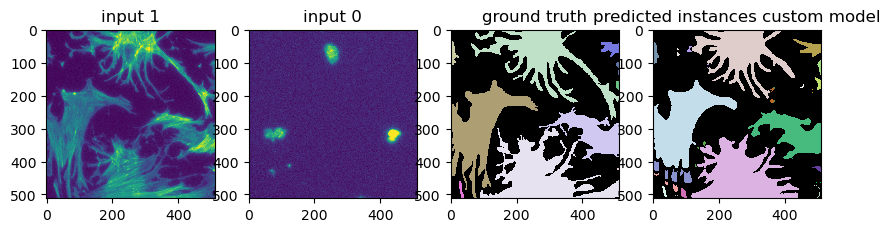

In [9]:
from tnia.plotting.plt_helper import random_label_cmap
# run model on test images
n=8
masks = model.eval(X_train[n], cellprob_threshold=-1, flow_threshold=0.8)
fig = imshow_multi2d([X_train[n][:,:,1], X_train[n][:,:,2], Y_train[n], masks[0]],['input 1','input 0', 'ground truth','predicted instances custom model'],1,4,colormaps=[None,None,random_label_cmap(),random_label_cmap()])


# test on whole image

In [12]:
from skimage.io import imread

In [15]:
im.dtype, im.min(), im.max()

(dtype('uint16'), 0, 65535)

2025-05-15 09:37:06,682 [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..257].


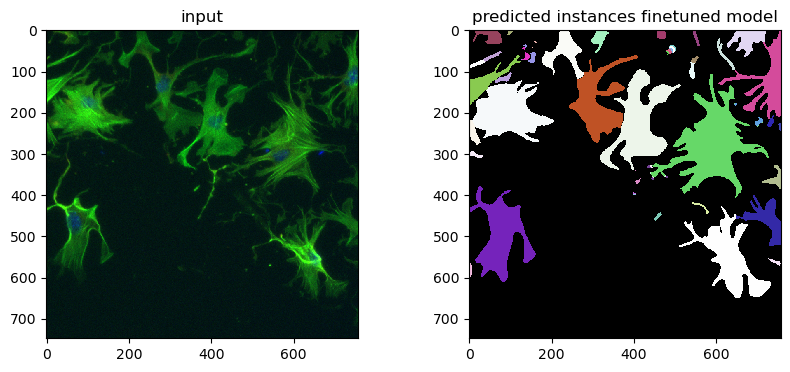

In [16]:


im = imread(r"D:\images\tnia-python-images\imagesc\2024_10_11_tough_cellpose_2\img63.tif")

masks = model.eval(im, cellprob_threshold=-1, flow_threshold=0.8)

fig = imshow_multi2d([im//255,  masks[0]],['input','predicted instances finetuned model'],1,2,colormaps=[None,random_label_cmap()])

## View in Napari

In [12]:
import napari
import pandas as pd

points = pd.read_csv(parent_path / 'Results.csv')
viewer = napari.Viewer()
viewer.add_image(testim, name='testim')
viewer.add_labels(labels, name='labels')
viewer.add_labels(labels_cyto2, name='labels_cyto2')
points_layer = viewer.add_points(points[['Y', 'X']], size=4, face_color='blue', name='points')

In [15]:
dir = r"D:\images\tnia-python-images\imagesc\2024_06_10_ladybugs\Archive"

files = os.listdir(dir)

In [16]:
len(files)

2301

In [20]:
files[0]

'10000827_13750024.jpg'